In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

## Receipt.ID
### Hierarchical text item classification
Taxonomic classification, categorize items according to a pre-defined taxonomy. The goal is to assign one or more categories in the taxonomy to an item. It is a multi-class **and** multi-label classification problem with hierarchical relationships between each node in the tree.

#### Items
- Items come from a wide range for categories like Produce, Meat, Beverage, Supplies. 
- Example item to category mapping:


|item|mapping|
|---|---|
|Kale  | "Food/Produce/Kale"  |
|Vinegar white wine 50 grain  | "Food/Dry-Grocery/Vinegars/White Wine Vinegar"  |
|Imported nat flank steak  | "Food/Meats/Beef/Flank Steak"  |

To solve this problem, I will undertake the following course of action:
1. Explore the dataset
    - Explore the dataset to ensure its integrity and understand the context. 
2. Identify features that may be used. 
    - If possible, engineer features that might provide greater discrimination.
3. Build k independent *text-based* classifiers for the text-based features and feed the output from these classifiers into the next layer classifier which takes in the other features. Explore a couple of classifiers that might be well suited for the problem at hand.
    - Decision Trees
    - SVM
    - AdaBoost
    - Random Forest
4.  Select appropriate classifier based on evaluation metric and tune it for optimality.

In this notebook I do processes 3 and 4.




In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import json

# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")  

# Use CPickle if available
try:
   import cPickle as pickle
except:
   import pickle

In [4]:
dataPath = '/Users/omojumiller/mycode/insight/PlateIQ/'
df = pd.read_pickle(dataPath+'data/df_data_vectors.dat')
df_catergory_lookup = pd.read_pickle(dataPath+'data/data_category_lookup.dat')
print ('Read in a data file with {0} datapoints'.format(len(df)))

Read in a data file with 127108 datapoints


In [5]:
# Define helper functions
from sklearn.model_selection import train_test_split

def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train, random_state=42)
    
    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [6]:
class MeanEmbeddingVectorizer(object):
    """Transforms lists of feature-value mappings to vectors.
    
    Attributes
    ----------
    object : word2vec model 
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    

In [46]:
def get_categories(level, num_data = 1000):
    """Gets categories which at least num_data datapoints.
    
    Attributes
    ----------
    level : column name
    num_data : int
    """    
    the_categories = {}
    counts = df.groupby(level).size()
    total = df.groupby(level).size().sum()
    
    for i in counts.index:
        if counts[i] > num_data:
            the_categories[int(i)] = counts[i]


    print(level, 'has', len(the_categories), 'categories with enough data.')  

    for key in the_categories:
        find_name = df_catergory_lookup.category_id == key
        name = df_catergory_lookup[find_name].category_name
        the_index = name.index[0]

    return the_categories, total

In [47]:
def get_category_name(key):
    """
    Get the name of a category
    Attributes
    ----------
    key : int
    """
    
    if key in df_catergory_lookup.category_id.unique():
        find_name = df_catergory_lookup.category_id == key
        name = df_catergory_lookup[find_name].category_name
        the_index = name.index[0]
        return name.ix[the_index]
    else:
        print(str(key)+" not in the dataframe")

## Current approach
The current approach used focuses exclusively on the item's name, for example, a data point in the dataset would have an object's name as "mary's organic fryers" or "organic baby spinach." The first challenge with this approach lay in the fact that the item label was quite short, roughly about two to eight words.  Further, when modifiers like *gluten free*, *organic*, or *pesticide free* wherein the item's label, this added a layer of misinformation causing items like *organic milk* and *organic beer* to be classified in the same class.


## My Approach
I took an entirely different approach. I got inspiration from the approach that Google, [YouTube](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36411.pdf) used in organizing videos and decided to shift the unit of analysis from item *name* to the *categories* themselves. My approach combines information from both the text-based labels as well as the item's metadata.

This method achieves two crucial things. First, by focusing on individual categories, each time a new category of item is added to the restaurant domain, instead of having to retrain the classifier on the entire dataset, all we have to do is gather enough data for that category, and train a classifier for it. This way, the approach can scale beautifully as the taxonomy grows. Second, moving the unit of analysis from text labels to categories, it becomes easier to correctly separate "organic cream" and "organic beer." 

I chose to discard categories that had less than 300 datapoints. As the datapoints in the category grows, those categories can then been trained individually.

In [8]:
the_level = {}
num_data = 300

level = 'level_0'
the_level[level], total = get_categories(level, num_data)

level_0 has 6 categories with enough data.


In [9]:
level = 'level_1'
the_level[level], total = get_categories(level, num_data)

level_1 has 19 categories with enough data.


In [10]:
level = 'level_2'
df.loc[:,('label')] = df.loc[:, level]
the_level[level], total = get_categories(level, num_data)

level_2 has 65 categories with enough data.


In [11]:
level = 'level_3'
df.loc[:,('label')] = df.loc[:, level]
the_level[level], total = get_categories(level, num_data)

level_3 has 42 categories with enough data.


In [12]:
level = 'level_4'
df.loc[:,('label')] = df.loc[:, level]
the_level[level], total = get_categories(level, num_data)

level_4 has 9 categories with enough data.


In [13]:
k_categories = 0
for key in the_level.keys():
    k_categories += len(the_level[key].keys())
   
    
print('processed {} categories in all'.format(k_categories))

processed 141 categories in all


### Labeling
For each data point, I assigned the deepest class node in the tree to which it belonged as its label. For example, an item named "bacon ends" belonged to both classes [Food], [Food, Meats] and [Food, Meats, Pork]. For such an item, I assigned it is label as "Pork."

In [14]:
null_examples = df['label'].isnull()
df.ix[df[null_examples].index, 'label'] = df.loc[:, 'level_4']

In [15]:
null_examples = df['label'].isnull()
df.ix[df[null_examples].index, 'label'] = df.loc[:, 'level_3']

In [16]:
null_examples = df['label'].isnull()
df.ix[df[null_examples].index, 'label'] = df.loc[:, 'level_2']

In [17]:
null_examples = df['label'].isnull()
df.ix[df[null_examples].index, 'label'] = df.loc[:, 'level_1']

In [18]:
null_examples_ = df['label'].isnull()
df.ix[df[null_examples_].index, 'label'] = df.loc[:, 'level_0']

### Retrieve the *k* training sets for the *k* categories for each level in the tree   
The aim of moving to a category-based solution is to embed knowledge of the taxonomy into classifiers. To do this, I had to figure out how to get positive and negative samples for each category. For every category node, I decided that itself, as well as all its descendants, were *positive* samples for that class. All other nodes that were neither the categories ancestor(s) or itself were set as *negative* samples.  The figure below gives a visual explanation of selecting category training set. I did this for each category node in the tree that had enough data.
<img src="images/hc_5.png" alt="Drawing" style="width: 450px;"/>

One of the limitations of this method is that most nodes have un-balanced classes. Some more severe than other, especially as you go further down in the tree. There are some classes whose ratio of positive signals is as small as 0.02%. The more granular that subclasses get, the harder it is to classify them. The good news is that one can decide to focus on a few of these classes and use synthetic methods to rebalance the dataset.

In [19]:
# Create a dict of positive and negative samples for the categories
category_samples = {}
category_positive_samples = {}
category_negative_samples= {}
category_test_samples = {}

In [44]:
level = 'level_0'
for key in the_level[level].keys():
    print ("processing {0}: {1}".format(key, get_category_name(key)))
    # create POSITIVE training set
    
    key_df = df[level] == key
    null_examples = df['level_1'].isnull()
    positive_examples = df['level_1'].notnull()
    

    # Create training set 
    try:
        category_samples[key] = df[key_df & null_examples]
        category_samples[key] = category_samples[key].append(df[key_df & positive_examples])
        num_test = (len(category_samples[key]) // 10) * 2
        category_positive_samples[key] = category_samples[key][num_test:]
        category_test_samples[key] = category_samples[key][:num_test]        

    except:
        print("This category didn't generate any feature set {0}".format(key))
        continue
        
    # create NEGATIVE training set
    level_0_item = df['level_0'] != key
    
    # Create training set 
    try:
        category_negative_samples[key] = df[level_0_item]
        
    except:
        print("This category didn't generate any label set {0}".format(key))
        continue
        
    
    
print("Finished Processing")




processing 1: Food
processing 2: Supplies
processing 3: Beverages
processing 4: Other
processing 495: Grocery
processing 499: Protein
Finished Processing


In [21]:
level = 'level_2'
for key in the_level[level].keys():
    print ("processing {0}: {1}".format(key, get_category_name(key)))
    # create POSITIVE training set
    
    key_df = df[level] == key
    null_examples = df['level_3'].isnull()
    positive_examples = df['level_3'].notnull()
    

    # Create training set 
    try:
        category_samples[key] = df[key_df & null_examples]
        category_samples[key] = category_samples[key].append(df[key_df & positive_examples])
        num_test = (len(category_samples[key]) // 10) * 2
        category_positive_samples[key] = category_samples[key][num_test:]
        category_test_samples[key] = category_samples[key][:num_test]    
    
    except:
        print("This category didn't generate any feature set {0}".format(key))
        continue
        
    # create NEGATIVE training set
    find_level_0 = df[level] == key
    name_level_0 = df[find_level_0].level_0
    the_index_level_0 = name_level_0.index[0]
    
    find_level_1 = df[level] == key
    name_level_1 = df[find_level_1].level_1
    the_index_level_1 = name_level_1.index[0]
    
    level_0_item = df['level_0'] != name_level_0.ix[the_index_level_0]
    level_1_item = df['level_1'] != name_level_1.ix[the_index_level_1]
    level_2_item = df['level_2'] != key
    
    # Create training set 
    try:
        category_negative_samples[key] = df[level_0_item & level_1_item & level_2_item]
        
    except:
        print("This category didn't generate any label set {0}".format(key))
        continue    
    
print("Finished Processing")



processing 1281: SF Checkout Bag Fee
processing 130: Cream
processing 375: Sausages
processing 132: Tomatoes
processing 134: Peppers
processing 391: Salt
processing 392: Disposables & Packaging Supplies
processing 267: Glasses
processing 258: Keg Deposit
processing 143: Tortillas
processing 16: Beers
processing 145: Cucumbers
processing 18: Wines
processing 531: Condiments
processing 535: Fruits
processing 152: Flour & Starch
processing 537: Herbs
processing 26: Juices
processing 157: Garlic
processing 1030: Seeds
processing 40: Teas
processing 44: Beans
processing 482: Linens
processing 177: Onions
processing 51: Fuel & Freight/Delivery
processing 1077: Breads
processing 54: Liquor
processing 55: Oils
processing 56: Pork
processing 1730: Leaves
processing 325: Eggs
processing 70: Beef
processing 456: Sodas
processing 329: Poultry
processing 74: Fish
processing 331: Coffee
processing 76: Spices
processing 226: Vinegars
processing 78: Cheese
processing 464: Canned
processing 1272: Squas

In [22]:
level = 'level_3'
for key in the_level[level].keys():
    print ("processing {0}: {1}".format(key, get_category_name(key)))
    # create POSITIVE training set
    
    key_df = df[level] == key
    null_examples = df['level_4'].isnull()
    positive_examples = df['level_4'].notnull()
    

    # Create training set 
    try:
        category_samples[key] = df[key_df & null_examples]
        category_samples[key] = category_samples[key].append(df[key_df & positive_examples])
        num_test = (len(category_samples[key]) // 10) * 2
        category_positive_samples[key] = category_samples[key][num_test:]
        category_test_samples[key] = category_samples[key][:num_test]        
  
    except:
        print("This category didn't generate any feature set {0}".format(key))
        continue
        
    # create NEGATIVE training set
    find_level_0 = df[level] == key
    name_level_0 = df[find_level_0].level_0
    the_index_level_0 = name_level_0.index[0]
    
    find_level_1 = df[level] == key
    name_level_1 = df[find_level_1].level_1
    the_index_level_1 = name_level_1.index[0]
    
    find_level_2 = df[level] == key
    name_level_2 = df[find_level_2].level_1
    the_index_level_2 = name_level_2.index[0]
    
    level_0_item = df['level_0'] != name_level_0.ix[the_index_level_0]
    level_1_item = df['level_1'] != name_level_1.ix[the_index_level_1]
    level_2_item = df['level_2'] != name_level_2.ix[the_index_level_2]
    level_3_item = df['level_3'] != key
    
    # Create training set 
    try:
        category_negative_samples[key] = df[level_0_item & level_1_item & level_2_item & level_3_item]
        
    except:
        print("This category didn't generate any label set {0}".format(key))
        continue    
    
print("Finished Processing")



processing 387: Oysters
processing 136: Cilantro
processing 1033: Ground Black Pepper
processing 1802: Baby Carrot
processing 1239: Lids
processing 275: Containers
processing 148: Olives
processing 25: Vodka
processing 282: Uniforms
processing 286: Bags
processing 32: Gin
processing 289: Cups
processing 164: Mints
processing 39: Tequila
processing 176: Oranges
processing 1160: Red Wines
processing 50: Iced Tea
processing 52: Whiskey
processing 437: Bacon
processing 1209: Gloves
processing 319: Red Onions
processing 963: Mozzarella
processing 69: Chicken
processing 970: Extra Virgin Olive Oil
processing 1200: Shrimp
processing 1358: Rice
processing 80: Apples
processing 355: Duck
processing 980: Dried Fruits
processing 983: Cheddar
processing 88: Avocados
processing 1113: Kegs
processing 95: Basil
processing 99: Bell Peppers
processing 229: Sauces
processing 998: White Wines
processing 363: Rum
processing 403: Purees
processing 247: Zucchini Squash
processing 1019: Salmon
processing 114

In [45]:
level = 'level_4'
for key in the_level[level].keys():
    print ("processing {0}: {1}".format(key, get_category_name(key)))
    # create POSITIVE training set
    
    key_df = df[level] == key
    null_examples = df['level_5'].isnull()
    positive_examples = df['level_5'].notnull()
    

    # Create training set 
    try:
        category_samples[key] = df[key_df & null_examples]
        category_samples[key] = category_samples[key].append(df[key_df & positive_examples])
        num_test = (len(category_samples[key]) // 10) * 2
        category_positive_samples[key] = category_samples[key][num_test:]
        category_test_samples[key] = category_samples[key][:num_test]        

    except:
        print("This category didn't generate any feature set {0}".format(key))
        continue
        
    # create NEGATIVE training set
    find_level_0 = df[level] == key
    name_level_0 = df[find_level_0].level_0
    the_index_level_0 = name_level_0.index[0]
    
    find_level_1 = df[level] == key
    name_level_1 = df[find_level_1].level_1
    the_index_level_1 = name_level_1.index[0]
    
    find_level_2 = df[level] == key
    name_level_2 = df[find_level_2].level_1
    the_index_level_2 = name_level_2.index[0]
    
    find_level_3 = df[level] == key
    name_level_3 = df[find_level_3].level_1
    the_index_level_3 = name_level_3.index[0]
    
    level_0_item = df['level_0'] != name_level_0.ix[the_index_level_0]
    level_1_item = df['level_1'] != name_level_1.ix[the_index_level_1]
    level_2_item = df['level_2'] != name_level_2.ix[the_index_level_2]
    level_3_item = df['level_3'] != name_level_3.ix[the_index_level_3]
    level_4_item = df['level_4'] != key
    
    # Create training set 
    try:
        category_negative_samples[key] = df[level_0_item & level_1_item & level_2_item & level_3_item & level_4_item]
        
    except:
        print("This category didn't generate any label set {0}".format(key))
        continue    
    
print("Finished Processing")



processing 35: Bourbon
processing 999: Cabernet Sauvignon
processing 1064: Chardonnay
processing 1002: Sauvignon Blanc
processing 1164: Brut
processing 49: Rye
processing 21: Rose Wine
processing 1015: Chicken Breast
processing 989: Pinot Noir
Finished Processing


## Modeling

With the training sets done, I vectorized them using a mean embedding vectorizer. 

### Classifier Selection
Based on how the positive and negative samples of the categories were generated, i.e., encoding the category hierarchy into the learning set, I inferred that the classes for each category would be linearly seperable. So for classifier selection, I experimented with an SVM, and AdaBoost and Random Forest. The SVM took too long to run for $K$ = 5 fold cross-validation. While AdaBoost ran faster, the score was lower than that of the Random Forest. Further, I could parallelize the Random Forest which significantly improved the running time.

For each category, I created an Random Forest binary classifier. I train each classifier using a $K=5$ fold cross-validation scheme. I fitted the resulting classifier and retrieved the predicted probability for each data point in the dataset, which resulted in *$K$* vectors for *$K$* categories. For each classifier, I calibrated its predicted probability by using an *isotonic* calibration.

#### Process item label names using Word2Vec

In [24]:
from gensim.models.word2vec import Word2Vec

# Only use item labels as input into word2vec embeddings
# train word2vec on all the item_labels 

w2v_model = Word2Vec(df['item_labels'], size=750, window=5, min_count=5, workers=4)
w2v = dict(zip(w2v_model.index2word, w2v_model.syn0))


In [25]:
w2v_model.init_sims(replace=True) #to trim unneeded model memory = use (much) less RAM.

#### Train *k* classifiers

In [26]:
from time import time, gmtime, strftime
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import RobustScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

seed = 342 # For reproducability
Ada_w2v =  Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                     ("Ada", AdaBoostClassifier(n_estimators=10))])

RF_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                     ("RF", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed))])


In [27]:
try:
    scores = joblib.load(dataPath+'data/df_category_scores.pkl')
except:
    scores = {}
try:
    pred_proba = joblib.load(dataPath+'data/df_category_pred_proba.pkl')
except:
    pred_proba = {}


In [31]:
t0 = time()


    
try:
    if (pred_proba <> {}) and (scores <> {}) :
        target = open(dataPath+'data/train_log_'+strftime("%d_%b_%Y_%H_%M_%S", gmtime())+'.txt', 'w')
        print("done in %0.3fs" % (time() - t0))
        target.close()
    
except:
    target = open(dataPath+'data/train_log_'+strftime("%d_%b_%Y_%H_%M_%S", gmtime())+'.txt', 'w')
    for key in category_positive_samples:
        if str(key) in scores:
            continue
        if key in scores:
            continue
        else:
        
            print ("processing {0}: {1}".format(key, get_category_name(key)))
            target.write("processing {0}: {1}\n".format(key, name.ix[the_index]))
            category_positive_samples[key].loc[:,('is_category')] = 1
            category_negative_samples[key].loc[:,('is_category')] = 0

            data = category_positive_samples[key].append(category_negative_samples[key], ignore_index=True)
            X = data['item_labels']
            y = data['is_category']
            target.write('{:5.3f}% positive samples\n'.format(len(category_positive_samples[key])/len(X)))
            target.write("Number of datapoints in set {}\n".format(len(X)))

            scores[key] = cross_val_score(RF_w2v,  X, y, cv=5, scoring='f1').mean()
            RF_w2v.fit(X, y)
            pred_proba[key] = RF_w2v.predict_proba(X)

            # persist model
            joblib.dump(RF_w2v, dataPath+'data/category_classifier/catg_'+str(key)+'.pkl')    
            print('Finished training category {0}: {1}\n'.format(key, name.ix[the_index]))
            target.write('Finished training category {0}: {1}\n\n'.format(key, name.ix[the_index]))

    target.close()    
    joblib.dump(scores, dataPath+'data/df_category_scores.pkl')
    joblib.dump(pred_proba,dataPath+'data/df_category_pred_proba.pkl')


done in 0.002s


#### Get *k* vectors

In [40]:
for key in category_positive_samples:
    if 'catg_'+str(key) in df:
        continue
    else:
        df_ = category_positiv_samples[key].append(category_negative_samples[key])
        scores_ = pd.DataFrame(pred_proba[key], columns = ['Neg','catg_'+str(key)])
        scores_.drop(['Neg'], axis = 1, inplace = True)
        scores_ = scores_.set_index(df_.index)
        df.ix[df_.index, 'catg_'+str(key)] = scores_

#### Write vectors to file

In [ ]:
df.to_pickle('data/df_data_vectors.dat')

### Final Model Architecture
<figure>
  <!---img src="images/hc_4.png" style="width: 450px;"--->
</figure>
After training the *k=141* classifiers, I extracted the *k* vectors; I carefully combined them with the engineered features, and the other raw metadata taking care to ensure that I assigned the right probabilities to the right data points in my training set. I feed these features and labels into a multi-label, multi-class Random Forest classifier. 

I took 75% of the data for training and 25% for testing. Once again I do a 5 fold cross-validation scheme, fit the final classifier, and retrieve the predicted class.


### Get Data for Final Classifier

#### Get Test set

In [41]:
try:
    data = joblib.load(dataPath+'data/data_test.pkl') 
except:
    # Merge all test datasets
    data = pd.DataFrame()
    for key in category_test_samples:
        data = data.append(category_test_samples[key], ignore_index=False)
    X_test_0 = data['item_labels']

    for keys in category_positive_samples:
        catg = 'catg_'+str(key)
        clf = joblib.load(dataPath+'data/category_classifier/'+catg+'.pkl')
        answer = clf.predict_proba(X_test_0)
        scores_ = pd.DataFrame(answer, columns = ['Neg',catg])
        scores_.drop(['Neg'], axis = 1, inplace = True)
        data.ix[:, catg] = scores_
        joblib.dump(clf, dataPath+'data/category_classifier/'+catg+'.pkl')

    joblib.dump(data, dataPath+'data/data_test.pkl') 

In [43]:
## Drop duplicates
data = data.drop_duplicates(['item_id'])

In [44]:
## Make sure you are testing on datapoints whose classifiers have been trained
label_mask_test = data[['label']].isin([key for key in scores.keys()]).all(axis=1)
data = data.ix[label_mask_test, ]

#### Get Training dataset

In [45]:
# Merge all training datasets

the_df = pd.DataFrame()
for key in category_positive_samples:
    the_df = the_df.append(category_positive_samples[key], ignore_index=False)

In [46]:
the_df = the_df.drop_duplicates(['item_id'], keep='last')

In [47]:
# drop rows that have the overlap between training and testing data from the training data

test_item_id = [x for x in data.item_id]
training_item_id = [x for x in the_df.item_id]
overlap = set(training_item_id).intersection(test_item_id)
mask = the_df[['item_id']].isin(list(overlap)).all(axis=1)
overlap_index = the_df.ix[mask].index 
the_df.drop(the_df.ix[mask].index, inplace = True)

### Train on present labels
For both training and testing, we can only train and test on datapoints whose category labels we have trained classifiers for.

In [48]:
label_mask_train = the_df[['label']].isin([key for key in scores.keys()]).all(axis=1)
the_df = the_df.ix[label_mask_train, ]

### Set training and  testing set

In [49]:
## Drop categories that we didn't train for in this implementation
col_name = ['label', u'item_id', u'price_stddev', u'primary_unit', u'price_mean',
 u'vendor_id', u'branch_lenght', u'item_name_match'] + ['catg_'+str(key) for key in scores.keys()]

In [50]:
X = the_df[col_name]

In [51]:
X = X[X['label'].notnull()]
y = X['label']
X = X.fillna(0)
X.drop(['label'], axis = 1, inplace = True)

In [52]:
category_mask = data[['label']].isin(y.unique()).all(axis=1)
X_test = data[category_mask]
X_test = X_test[col_name]

In [53]:
y_test = X_test['label']
X_test = X_test.fillna(0)
X_test.drop(['label'], axis = 1, inplace = True)

In [54]:
X_test.tail()

,item_id,price_stddev,primary_unit,price_mean,vendor_id,branch_lenght,item_name_match,catg_1,catg_2,catg_3,...,catg_989,catg_482,catg_998,catg_999,catg_1002,catg_495,catg_499,catg_1015,catg_1019,catg_1021
55507,349603,0.000000,3,52.000000,8738,4,1.0,0.9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
55508,352946,5.630275,3,31.800000,7280,4,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
55509,355295,0.000000,3,13.950000,9724,4,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55510,360428,0.000000,3,7.500000,1146,4,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0
55511,362518,0.638381,3,9.128294,22,4,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0


In [55]:
X.head()

,item_id,price_stddev,primary_unit,price_mean,vendor_id,branch_lenght,item_name_match,catg_1,catg_2,catg_3,...,catg_989,catg_482,catg_998,catg_999,catg_1002,catg_495,catg_499,catg_1015,catg_1019,catg_1021
106620,553484,0.6,7,31.29,1475,3,0.0,0.206667,0.01,0.685000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106900,562929,0.0,4,54.55,1244,3,0.0,0.060000,0.01,0.880000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106967,565698,0.0,1,35.90,1745,3,0.0,0.030000,0.01,0.936667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106971,565756,0.0,7,140.95,1475,3,0.0,0.020000,0.02,0.903333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107166,573430,0.0,1,198.50,821,3,0.0,0.090000,0.00,0.834000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train final classifier

In [56]:
models = {
          'DecisionTree': DecisionTreeClassifier(random_state=seed),
          'RandomForest': RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=seed),
         }

scaler = RobustScaler()
X_transform = scaler.fit_transform(X)
X_test_transform  = scaler.fit_transform(X_test)

print(X_transform.shape)
print(X_test_transform.shape)

(17015, 129)
(9575, 129)


In [57]:
print('CLASSIFICATION RESULTS OF BASELINE CLASSIFIERS\n')
print('{:20}{:^15}{:^10}{:^10}'.format('CLASSIFIER', 'MEAN SCORE %', 'STD DEV %', 'TIME'))


for clf_name, clf in models.iteritems():
    t0 = time()
    results = cross_val_score(clf, X_transform, y, cv=5)
    t1 = time() - t0
    print('{:20}{:^15.2f}{:^10.2f}{:>10.2f}secs'.format(clf_name, results.mean()*100, results.std()*100, t1))
    

CLASSIFICATION RESULTS OF BASELINE CLASSIFIERS

CLASSIFIER           MEAN SCORE %  STD DEV %    TIME   
DecisionTree             98.95        0.29         3.28secs
RandomForest             99.10        0.19         2.38secs


In [58]:
t0 = time()

clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=seed)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(X_transform, y)
final_preds = calibrated_clf.predict(X_test_transform)
precision, recall, fbeta_score, support = score(y_test, final_preds)




print ("Precision: {:10.3f}\nRecall: {:^10.3f}\nF Score{:^10.3f}\nSupport:{:^10.3f}\nChance:{:^10.3f}".format(precision.mean()*100, 
                                                 recall.mean()*100, fbeta_score.mean()*100, len(support), (1/len(support))*100))

print("{:<5.2f}secs".format(time() - t0))

Precision:     46.366
Recall:   38.332  
F Score  33.905  
Support:  63.000  
Chance:  1.587   
182.90secs


## Results
|Tree Level|mapping|Precision|Recall|Chance|
|---|---|---|---|---|
|One |92% |94% |90% | 25%|
|Two | 66%| 80%| 64%| 7.0%|
|Three | 47%|60% |48% | 2.5%|
|Four|39% |44% |50% |3.0% |

In [60]:
## Let's take a look at the results
df_output = pd.DataFrame()
df_output['truth'] = y_test
df_output['predicted'] = final_preds
df_output['predicted_name'] = ''
df_output['item_name'] = data['item_name']
df_output['mapped_level_0'] = data['mapped_level_0']
df_output['level_0'] = data['level_0']
df_output['preds_level_0'] = NaN
df_output['mapped_level_1'] = data['mapped_level_1']
df_output['level_1'] = data['level_1']
df_output['preds_level_1'] = NaN
df_output['mapped_level_2'] = data['mapped_level_2']
df_output['level_2'] = data['level_2']
df_output['preds_level_2'] = NaN
df_output['mapped_level_3'] = data['mapped_level_3']
df_output['level_3'] = data['level_3']
df_output['preds_level_3'] = NaN
df_output['mapped_level_4'] = data['mapped_level_4']
df_output['level_4'] = data['level_4']
df_output['preds_level_4'] = NaN

In [61]:
for i in list(df_output.index):
    # find the a record where label is the predicted value
    the_query = df.ix[:, 'label'] == df_output.ix[i, 'predicted']
    answer = df[the_query].head(1)[['item_name', 'level_0', 'level_1', 'level_2', 'level_3', 'level_4']]
    df_output.ix[i, 'predicted_name'] = answer.item_name.values[0]
    df_output.ix[i, 'preds_level_0'] = answer.level_0.values[0]
    df_output.ix[i, 'preds_level_1'] = answer.level_1.values[0]
    df_output.ix[i, 'preds_level_2'] = answer.level_2.values[0]
    df_output.ix[i, 'preds_level_3'] = answer.level_3.values[0]
    df_output.ix[i, 'preds_level_4'] = answer.level_4.values[0]

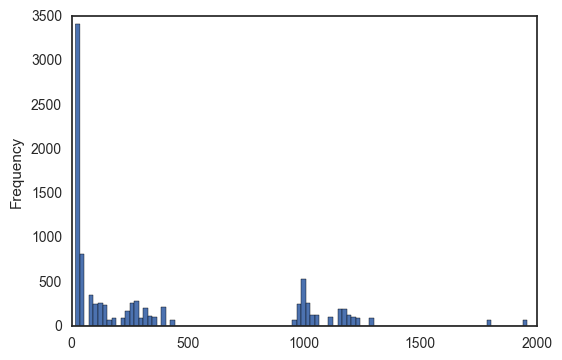

In [62]:
plt.rcParams['figure.figsize'] = (6, 4)
df_output['truth'].plot.hist(bins=100);

In [63]:
df_output.head()

,truth,predicted,predicted_name,item_name,mapped_level_0,level_0,preds_level_0,mapped_level_1,level_1,preds_level_1,mapped_level_2,level_2,preds_level_2,mapped_level_3,level_3,preds_level_3,mapped_level_4,level_4,preds_level_4
432,95.0,35.0,noah's mill 114.3 pf bourbon,basil - pesticide free,Food,1,3.0,Produce,9.0,6.0,Herbs,537.0,54.0,Basil,95.0,52.0,NaN,NaN,35.0
433,95.0,95.0,basil - pesticide free,basil-lb pest-free,Food,1,1.0,Produce,9.0,9.0,Herbs,537.0,537.0,Basil,95.0,95.0,NaN,NaN,NaN
444,157.0,157.0,garlic super colossal,garlic super colossal,Food,1,1.0,Produce,9.0,9.0,Garlic,157.0,157.0,NaN,NaN,NaN,NaN,NaN,NaN
454,176.0,176.0,oranges 56ct,oranges 56ct,Food,1,1.0,Produce,9.0,9.0,Fruits,535.0,535.0,Oranges,176.0,176.0,NaN,NaN,NaN
455,176.0,176.0,oranges 56ct,oranges 72ct,Food,1,1.0,Produce,9.0,9.0,Fruits,535.0,535.0,Oranges,176.0,176.0,NaN,NaN,NaN


In [64]:
df_output = df_output.fillna(0)

In [65]:
## First Level

In [66]:
precision, recall, fbeta_score, support = score(df_output.level_0, df_output.preds_level_0)
print ("Precision: {:10.3f}\nRecall: {:^10.3f}\nF Score{:^10.3f}\nSupport:{:^10}\nChance:{:^10.3f}".format(precision.mean()*100, 
                                                 recall.mean()*100, fbeta_score.mean()*100, len(support), (1/len(support))*100))

Precision:     94.489
Recall:   90.365  
F Score  92.267  
Support:    4     
Chance:  25.000  


In [67]:
## Second Level

In [68]:
precision, recall, fbeta_score, support = score(df_output.level_1, df_output.preds_level_1)
print ("Precision: {:10.3f}\nRecall: {:^10.3f}\nF Score{:^10.3f}\nSupport:{:^10}\nChance:{:^10.3f}".format(precision.mean()*100, 
                                                 recall.mean()*100, fbeta_score.mean()*100, len(support), (1/len(support))*100))

Precision:     79.803
Recall:   64.363  
F Score  66.517  
Support:    14    
Chance:  7.143   


In [69]:
## Third Level

In [70]:
precision, recall, fbeta_score, support = score(df_output.level_2, df_output.preds_level_2)
print ("Precision: {:10.3f}\nRecall: {:^10.3f}\nF Score{:^10.3f}\nSupport:{:^10}\nChance:{:^10.3f}".format(precision.mean()*100, 
                                                 recall.mean()*100, fbeta_score.mean()*100, len(support), (1/len(support))*100))

Precision:     60.151
Recall:   48.520  
F Score  47.016  
Support:    39    
Chance:  2.564   


In [71]:
## Fourth Level

In [72]:
precision, recall, fbeta_score, support = score(df_output.level_3, df_output.preds_level_3)
print ("Precision: {:10.3f}\nRecall: {:^10.3f}\nF Score{:^10.3f}\nSupport:{:^10.3f}\nChance:{:^10.3f}".format(precision.mean()*100, 
                                                 recall.mean()*100, fbeta_score.mean()*100, len(support), (1/len(support))*100))

Precision:     44.091
Recall:   50.211  
F Score  39.591  
Support:  33.000  
Chance:  3.030   
